In [4]:
!pip install geopy
from geopy.distance import geodesic as GD

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [5]:
!pip install folium

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [6]:
import pandas as pd
import datetime
import folium
import sqlite3
from sqlalchemy import create_engine
from sqlalchemy import inspect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', 
    style='white', 
    font_scale=1.1)

In [7]:
#Connecting to database
engine = create_engine("sqlite:///mta_data.db")
insp=inspect(engine)
print(insp.get_table_names())

['MTA_LAT_LONG', 'citibike_stations', 'citibike_trips_ny', 'mta_data']


# Part 1: MTA Data Analysis

In [13]:
#Loading the data in a df
mta_df= pd.read_sql('SELECT CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS FROM mta_data\
                    WHERE (ENTRIES IS NOT NULL) OR (EXITS IS NOT NULL);',engine)
mta_df.head()

,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,05/21/2022,00:00:00,7714568,2706545
1,A002,R051,02-00-00,59 ST,05/21/2022,04:00:00,7714583,2706554
2,A002,R051,02-00-00,59 ST,05/21/2022,08:00:00,7714590,2706575
3,A002,R051,02-00-00,59 ST,05/21/2022,12:00:00,7714641,2706648
4,A002,R051,02-00-00,59 ST,05/21/2022,16:00:00,7714728,2706690


## Intial Data Cleaning

In [14]:
#Cleaning column names
mta_df.columns = [column.strip() for column in mta_df.columns]

In [15]:
#Checking for null values 

In [16]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10924329 entries, 0 to 10924328
Data columns (total 8 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   CA       object
 1   UNIT     object
 2   SCP      object
 3   STATION  object
 4   DATE     object
 5   TIME     object
 6   ENTRIES  int64 
 7   EXITS    int64 
dtypes: int64(2), object(6)
memory usage: 666.8+ MB


In [17]:
#Combining DATE and TIME columns into a datetime column for analysis 
mta_df["DATE_TIME"] = pd.to_datetime(mta_df.DATE + " " + mta_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [18]:
#Removing duplicates

#Each CA/UNIT/SCP/STATION/DATE_TIME combination represents a unique tursnstile and should have only one value for ENTRIES and EXITS
#Checking if there are more than one value for ENTRIES for each combo of: CA/UNIT/SCP/STATION
(mta_df
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)


,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
911113,B022,R229,00-05-02,AVENUE M,2021-12-21 15:00:00,2
10838022,S101,R070,00-00-02,ST. GEORGE,2021-09-09 12:00:00,2
8752255,R249,R179,01-05-01,86 ST,2022-05-01 12:00:00,2
10838019,S101,R070,00-00-02,ST. GEORGE,2021-09-09 00:00:00,2
1620753,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 08:00:00,2
1620754,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 12:00:00,2
1620755,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 16:00:00,2
1620756,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 20:00:00,2
1620757,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-08 00:00:00,2
10838013,S101,R070,00-00-02,ST. GEORGE,2021-09-08 00:00:00,2


In [19]:
#Doing the same check for EXITS 
(mta_df
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)

,CA,UNIT,SCP,STATION,DATE_TIME,EXITS
911113,B022,R229,00-05-02,AVENUE M,2021-12-21 15:00:00,2
10838022,S101,R070,00-00-02,ST. GEORGE,2021-09-09 12:00:00,2
8752255,R249,R179,01-05-01,86 ST,2022-05-01 12:00:00,2
10838019,S101,R070,00-00-02,ST. GEORGE,2021-09-09 00:00:00,2
1620753,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 08:00:00,2
1620754,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 12:00:00,2
1620755,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 16:00:00,2
1620756,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-07 20:00:00,2
1620757,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-08 00:00:00,2
10838013,S101,R070,00-00-02,ST. GEORGE,2021-09-08 00:00:00,2


In [20]:
#Dropping Duplicates
mta_df.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta_df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [21]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10924082 entries, 211706 to 10714798
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   CA         object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   DATE       object        
 5   TIME       object        
 6   ENTRIES    int64         
 7   EXITS      int64         
 8   DATE_TIME  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 833.4+ MB


## Calculating Entries and Exits per Day per Turnstile

In [22]:
#Looking at the data for one specific turnstiles we notice the following:
#Entries and exits are recorded at four hour interval every day. 
#The values for entries and exits are cumulative:the last value of the day should be the largest
mta_df[(mta_df["CA"] == "A011") & 
(mta_df["UNIT"] == "R080") & 
(mta_df["SCP"] == "01-00-00") & 
(mta_df["STATION"] == "57 ST-7 AV") &
(mta_df["DATE"] == "05/27/2022")]

,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
1469,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,20:00:00,559830,2122305,2022-05-27 20:00:00
1468,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,16:00:00,559764,2121888,2022-05-27 16:00:00
1467,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,12:00:00,559714,2121468,2022-05-27 12:00:00
1466,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,08:00:00,559682,2121045,2022-05-27 08:00:00
1465,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,04:00:00,559677,2120872,2022-05-27 04:00:00
1464,A011,R080,01-00-00,57 ST-7 AV,05/27/2022,00:00:00,559673,2120850,2022-05-27 00:00:00


In [23]:
#Turning DATE and TIME columns into actual date and time columns for Sorting Purposes

In [24]:
mta_df['DATE']=mta_df['DATE'].astype('datetime64[ns]')
mta_df['TIME']=mta_df['TIME'].astype('datetime64[ns]')

In [25]:
#Because the values are cumulative in order to get the cumulative number of entries and exits in a day:
#We select the last reading of the day. This gives us the cumulative number of entries on this day
#The data being sorted in descending order, the latest time for each turnstile is the first value
mta_daily = (mta_df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.first())

#Adding the EXIT column to mta_daily
mta_daily["EXITS"]=(mta_df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False).EXITS.first()).EXITS


In [26]:
#At this stage mta_daily displays the cumulative number of entries and exits per day
#In order to get the actual number of entries and exits per day per turnstile
#So, For each turnstile, I need to substract each daily entries/exits by the daily entries/exits on the previous day 
mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [27]:
mta_daily

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2021-05-29,7579021,2590439,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,2021-05-30,7579275,2590548,2021-05-29,7579021.0,2590439.0
2,A002,R051,02-00-00,59 ST,2021-05-31,7579593,2590641,2021-05-30,7579275.0,2590548.0
3,A002,R051,02-00-00,59 ST,2021-06-01,7580178,2590917,2021-05-31,7579593.0,2590641.0
4,A002,R051,02-00-00,59 ST,2021-06-02,7580754,2591200,2021-06-01,7580178.0,2590917.0
...,...,...,...,...,...,...,...,...,...,...
1822822,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2022-05-23,0,369,2022-05-22,0.0,363.0
1822823,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2022-05-24,0,377,2022-05-23,0.0,369.0
1822824,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2022-05-25,0,380,2022-05-24,0.0,377.0
1822825,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2022-05-26,0,382,2022-05-25,0.0,380.0


In [28]:
#Checking that the values that have no PREV_ENTRies correspond to the first date in the dataset
mta_daily[mta_daily['PREV_ENTRIES'].isna()].DATE.unique

<bound method Series.unique of 0         2021-05-29
364       2021-05-29
728       2021-05-29
1092      2021-05-29
1456      2021-05-29
             ...    
1821007   2021-05-29
1821371   2021-05-29
1821735   2021-05-29
1822099   2021-05-29
1822463   2021-05-29
Name: DATE, Length: 5077, dtype: datetime64[ns]>

In [29]:
#Dropping the first date in the dataset
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
mta_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817750 entries, 1 to 1822826
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   CA            object        
 1   UNIT          object        
 2   SCP           object        
 3   STATION       object        
 4   DATE          datetime64[ns]
 5   ENTRIES       int64         
 6   EXITS         int64         
 7   PREV_DATE     datetime64[ns]
 8   PREV_ENTRIES  float64       
 9   PREV_EXITS    float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 152.6+ MB


## Second Round of Cleaning: Entries and Exits Values

In [30]:
#Seeing if Actual Entries values make sense

# First, checking for negatives: Looks like there are a few 
(mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]]
    .groupby(["CA", "UNIT", "SCP", "STATION","DATE"])
    .size())

CA     UNIT  SCP       STATION        DATE      
A010   R080  00-00-01  57 ST-7 AV     2022-05-07    1
             00-00-02  57 ST-7 AV     2022-05-07    1
             00-00-03  57 ST-7 AV     2022-05-07    1
A011   R080  01-00-01  57 ST-7 AV     2022-04-29    1
             01-03-00  57 ST-7 AV     2021-05-30    1
                                                   ..
S101   R070  00-00-02  ST. GEORGE     2021-09-30    1
                                      2021-10-03    1
             00-00-03  ST. GEORGE     2022-03-02    1
S101A  R070  01-05-00  ST. GEORGE     2022-04-11    1
TRAM2  R469  00-05-01  RIT-ROOSEVELT  2022-01-02    1
Length: 18530, dtype: int64

In [31]:
#Second checking for non-sensical values:
#The counter for a day is a sum of values that amount to 24 hours 
#Taking 1 day if we assume that 1 person is passing the turnstile per sec
#That means in a day a maximum of 86400 ENTRIES OR EXITS A TURNSTILE would make sense 

In [32]:
(mta_daily[mta_daily["ENTRIES"]- mta_daily["PREV_ENTRIES"]>86400]
    .groupby(["CA", "UNIT", "SCP", "STATION","DATE"])
    .size())

CA     UNIT  SCP       STATION        DATE      
A082   R028  05-05-01  FULTON ST      2021-09-12    1
B019   R149  00-00-01  NEWKIRK PLAZA  2022-03-11    1
B020   R263  00-06-01  AVENUE H       2021-11-22    1
B023   R211  01-05-00  KINGS HWY      2021-10-26    1
C008   R099  00-04-01  DEKALB AV      2021-10-26    1
                                                   ..
S101   R070  00-00-02  ST. GEORGE     2021-09-16    1
                                      2021-09-20    1
                                      2021-10-01    1
             00-00-04  ST. GEORGE     2022-03-02    1
TRAM2  R469  00-05-00  RIT-ROOSEVELT  2021-11-24    1
Length: 104, dtype: int64

In [33]:
#A few observations:
#Negatives mean that the counter is counting in reverse, the value should be an absolute value of Entries-Prev Entries
#There a few non-sensical values that are above the defined logical maximum of 84600

In [34]:
#The function below takes care of this: 

In [35]:
def get_daily_counts(row, max_counter,current_value,previous_value):
    counter = row[current_value] - row[previous_value]
    if counter < 0:
        # Keeping the absolute value for Entries/Exits - Prev Entries/Exits
        counter = -counter
    if counter > max_counter:
        # Filtering values that don't make sense based on the logical maximum 
        print(row[current_value], row[previous_value])
        counter = min(row[current_value], row[previous_value])
    if counter > max_counter:
        # Check it again to make sure the logical maximum of 84600
        return 0
    return counter

In [36]:
#Calculating Daily Entries 

In [37]:
mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=84600,current_value='ENTRIES',
                                            previous_value='PREV_ENTRIES')

280 15855093.0
157 11599257.0
169 3985295.0
307 836725.0
50 5264647.0
70 317555.0
846 7354911.0
544 140377.0
233 93377.0
6 5597786.0
233 1951349.0
93 765803.0
393216 1.0
5 150038.0
750 16365531.0
14 9950892.0
550698591 14.0
393223 42214.0
111 118122.0
0 317605.0
393220 913.0
353 8049630.0
327680 67108864.0
393216 3.0
999 672037.0
128 1458351.0
162 643913.0
12 468610.0
458752 24.0
114 526675.0
359 209354.0
1245462 691286.0
343 4179055.0
10 327687.0
327700 0.0
0 327700.0
11 3622304.0
24 453053819.0
419 501459.0
121 316354.0
177 267760.0
63 191894.0
78 212187.0
1562967890 113672.0
41 1562955740.0
686 114845.0
458754 262214.0
8 458758.0
393219 2408.0
180 2900739.0
0 925201.0
167790157 702266.0
58 317664.0
63 9631506.0
310 5609562.0
351 132517.0
206 247237.0
35 9768753.0
307 3295646.0
33565227 188178.0
48 8724126.0
0 185094.0
2 242887.0
458768 2578.0
327680 459304.0
65536 327680.0
458752 1.0
327710 1560335855.0
0 328007.0
999 2121718.0
65 106396.0
3849 148271.0
117453575 459314.0
66 191378.

In [38]:
mta_daily.sort_values(by='DAILY_ENTRIES')
#We can see that the now: the minimum DAILY_ENTRIES is 0 and the maximum is below 84600

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES
1822826,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2022-05-27,0,388,2022-05-26,0.0,382.0,0.0
1552319,R325,R388,00-05-01,E 180 ST,2021-12-01,3,668,2021-11-30,3.0,666.0,0.0
1552318,R325,R388,00-05-01,E 180 ST,2021-11-30,3,666,2021-11-29,3.0,664.0,0.0
1552317,R325,R388,00-05-01,E 180 ST,2021-11-29,3,664,2021-11-28,3.0,663.0,0.0
1552316,R325,R388,00-05-01,E 180 ST,2021-11-28,3,663,2021-11-27,3.0,663.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1125548,PTH22,R540,00-02-07,PATH NEW WTC,2021-07-09,337,85,2021-07-08,82765.0,24577.0,82428.0
1755937,R621,R060,00-06-00,EASTN PKWY-MUSM,2021-08-26,185,216,2021-08-25,82744.0,88335.0,82559.0
1125145,PTH22,R540,00-02-05,PATH NEW WTC,2022-05-24,581,48,2022-05-23,83407.0,58291.0,82826.0
151310,B022,R229,00-05-02,AVENUE M,2022-01-09,18,35,2022-01-08,83807.0,60158.0,83789.0


In [39]:
mta_daily["DAILY_EXITS"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=84600,current_value='EXITS',
                                            previous_value='PREV_EXITS')

317 6428295.0
165 4757007.0
102 2006195.0
932 1408602.0
85 5980618.0
282 948186.0
589 5976643.0
693 218430.0
358 126802.0
546 454387.0
1 8162609.0
1329 4753462.0
218 1653807.0
523 9011215.0
1024 11719706.0
467794917 1024.0
12 124871.0
264 283641.0
165 2357391.0
0 16777478.0
356 254659.0
68 473497.0
196 346839.0
1010 689571.0
146 128667.0
541 207188.0
460 219885.0
961 6516739.0
262144 0.0
51 1838548.0
11 268452929.0
82 156715.0
240 312732.0
276 778911.0
1562963755 1362410.0
5276 1562778068.0
978 468326.0
513 16949437.0
3 2006536.0
268473848 1083083.0
34 144277.0
75 1318622.0
633 2245979.0
1 1076665.0
694 5516171.0
100678103 411664.0
65 8512839.0
146 94721.0
50 166689.0
0 96658.0
524288 0.0
262150 175.0
1 262151.0
6 1056988739.0
2633180 490990.0
602 1025567.0
2603 465251.0
175 145669.0
224 213092.0
26 2284200.0
259 160229.0
837 447208.0
481794 2356.0
656 504504.0
0 202701.0
3501 491500.0
576 205674.0
676 274285.0
131078 98.0
713 2544401.0
297 479104.0
11 123076.0
323 161084.0
37 654181.0

## Looking at Traffic at  the Station Level

In [40]:
#Grouping mta_daily by station
station_daily = mta_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES','DAILY_EXITS']].sum().reset_index()
station_daily.head()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,2021-05-30,4575.0,8830.0
1,1 AV,2021-05-31,4943.0,8936.0
2,1 AV,2021-06-01,7487.0,12730.0
3,1 AV,2021-06-02,7993.0,13067.0
4,1 AV,2021-06-03,7844.0,13031.0


In [41]:
#Adding a total Traffic Column : DAILY_ENTRIES + DAILY_EXITS
station_daily['TOTAL_TRAFFIC'] = station_daily["DAILY_ENTRIES"]+station_daily["DAILY_EXITS"]

In [42]:
#station_daily['WEEK_DAY']=

<AxesSubplot:xlabel='WEEKDAY', ylabel='TOTAL_TRAFFIC'>

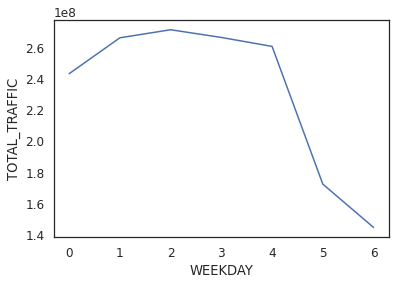

In [43]:
station_day_of_week=station_daily.copy()
station_day_of_week['WEEKDAY']=station_day_of_week.DATE.dt.dayofweek
station_day_of_week_2=station_day_of_week.groupby('WEEKDAY')['TOTAL_TRAFFIC'].sum().reset_index()

sns.lineplot(x='WEEKDAY',y='TOTAL_TRAFFIC',data=station_day_of_week_2)

In [44]:
mask=(station_day_of_week['WEEKDAY']==5) | (station_day_of_week['WEEKDAY']==6) 
station_day_of_weekend=station_day_of_week[mask].groupby('STATION').TOTAL_TRAFFIC.sum().reset_index()
station_day_of_weekend=station_day_of_weekend.sort_values('TOTAL_TRAFFIC',ascending=False).head(30)

In [45]:
station_day_of_week_=station_day_of_week[~mask].groupby('STATION').TOTAL_TRAFFIC.sum().reset_index()
station_day_of_week_=station_day_of_week_.sort_values('TOTAL_TRAFFIC',ascending=False).head(30)

In [46]:
a=set(station_day_of_weekend.STATION)
b=set(station_day_of_week_.STATION)
b-a

{'47-50 STS ROCK', '7 AV', 'CHURCH AV', 'JAMAICA CENTER', 'JOURNAL SQUARE'}

In [47]:
a-b

{'1 AV', '8 AV', 'BEDFORD AV', 'DELANCEY/ESSEX', 'GRAND ST'}

In [48]:
#Calculating cumulative Traffic
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()
station_totals


,STATION,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC
0,34 ST-PENN STA,17146189.0,24826860.0,41973049.0
1,GRD CNTRL-42 ST,12844301.0,19543523.0,32387824.0
2,34 ST-HERALD SQ,13074993.0,18757202.0,31832195.0
3,86 ST,11639581.0,16443725.0,28083306.0
4,14 ST-UNION SQ,10845407.0,16872027.0,27717434.0
...,...,...,...,...
374,BEACH 98 ST,73037.0,118362.0,191399.0
375,TOMPKINSVILLE,111996.0,7.0,112003.0
376,BEACH 105 ST,39685.0,69834.0,109519.0
377,ORCHARD BEACH,792.0,75236.0,76028.0


In [49]:
station_totals_pickled=station_totals.to_pickle("./station_totals_picked.pkl")  

In [50]:
stations_totals_unpickled= pd.read_pickle("./station_totals_picked.pkl") 

In [51]:
stations_totals_unpickled

,STATION,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC
0,34 ST-PENN STA,17146189.0,24826860.0,41973049.0
1,GRD CNTRL-42 ST,12844301.0,19543523.0,32387824.0
2,34 ST-HERALD SQ,13074993.0,18757202.0,31832195.0
3,86 ST,11639581.0,16443725.0,28083306.0
4,14 ST-UNION SQ,10845407.0,16872027.0,27717434.0
...,...,...,...,...
374,BEACH 98 ST,73037.0,118362.0,191399.0
375,TOMPKINSVILLE,111996.0,7.0,112003.0
376,BEACH 105 ST,39685.0,69834.0,109519.0
377,ORCHARD BEACH,792.0,75236.0,76028.0


# Part 2: Citibike Trips Data Analysis

In [5]:
#Loading data from SQL database the dataset with the latitude and longitude info of MTA Stations

In [6]:
citibike_trips= pd.read_sql('SELECT ride_id,started_at,ended_at,start_station_name,end_station_name\
                            FROM citibike_trips_ny\
                            WHERE (start_station_name IS NOT NULL) or (end_station_name IS NOT NULL)',engine)
citibike_trips.head()

,ride_id,started_at,ended_at,start_station_name,end_station_name
0,4B923B054861DAEF,2021-06-01 23:12:34,2021-06-01 23:14:46,Driggs Ave & N 9 St,Bayard St & Leonard St
1,7F5D78629F671C01,2021-06-16 17:14:56,2021-06-16 17:29:15,Fulton St & Broadway,Mercer St & Spring St
2,3F11FC94B816A370,2021-06-07 19:41:55,2021-06-07 19:51:28,Devoe St & Lorimer St,Manhattan Av & Leonard St
3,9116683DA18320D9,2021-06-17 15:13:15,2021-06-17 15:33:25,Driggs Ave & N 9 St,Greenwich Ave & Charles St
4,FBBF59A0A03AC3AF,2021-06-18 08:27:03,2021-06-18 08:53:37,Graham Ave & Conselyea St,E 30 St & Park Ave S


## Data Cleaning

In [7]:
#Double Checking for null values

In [8]:
citibike_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29032750 entries, 0 to 29032749
Data columns (total 5 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   ride_id             object
 1   started_at          object
 2   ended_at            object
 3   start_station_name  object
 4   end_station_name    object
dtypes: object(5)
memory usage: 1.1+ GB


In [9]:
#Dropping duplicates

In [10]:
citibike_trips.drop_duplicates(subset=['ride_id'],inplace=True)
#Dropping ride_id column

In [11]:
citibike_trips=citibike_trips.drop(columns=['ride_id'])

In [12]:
citibike_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29032740 entries, 0 to 29032749
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   started_at          object
 1   ended_at            object
 2   start_station_name  object
 3   end_station_name    object
dtypes: object(4)
memory usage: 1.1+ GB


In [13]:
#Cleaning column names
citibike_trips.columns

Index(['started_at', 'ended_at', 'start_station_name', 'end_station_name'], dtype='object')

In [14]:
#Converting starttime and stoptime to datetime and calculating trip duration

citibike_trips['trip_duration']=((pd.to_datetime(citibike_trips['ended_at'],errors='coerce')\
                                 -(pd.to_datetime(citibike_trips['started_at'],errors='coerce')))).dt.total_seconds()

In [15]:
#Dropping started_at and ended_end

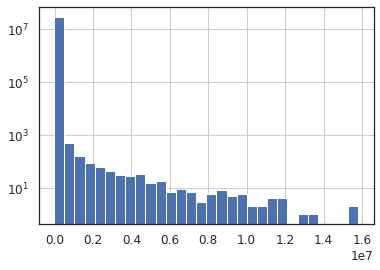

In [16]:
#Plotting trip_duration
citibike_trips['trip_duration'].hist(bins=30).set_yscale('log')

In [17]:
#Dropping any trip above 12000000, seems non-sensical 
citibike_trips = citibike_trips[citibike_trips['trip_duration'] <= 12000000]

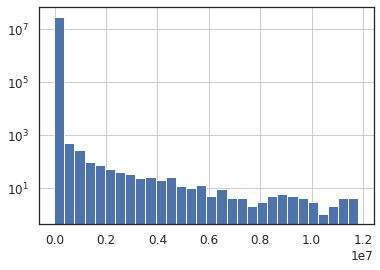

In [18]:
citibike_trips['trip_duration'].hist(bins=30).set_yscale('log')

In [19]:
#Checking for start and end dates that are the same with a trip_duration time below 1 min

In [20]:
mask= (citibike_trips['trip_duration'] <= 60\
        & (citibike_trips['start_station_name']== citibike_trips['end_station_name']))

In [21]:
citibike_trips[mask]

,started_at,ended_at,start_station_name,end_station_name,trip_duration
14470,2021-06-10 19:27:43,2021-06-10 19:27:43,W 27 St & 7 Ave,None,0.0
14535,2021-06-04 08:26:35,2021-06-04 08:26:35,Lexington Ave & E 29 St,None,0.0
14624,2021-06-01 15:09:16,2021-06-01 15:09:16,1 Ave & E 62 St,None,0.0
14871,2021-06-27 00:08:56,2021-06-27 00:08:56,W 63 St & Broadway,None,0.0
15137,2021-06-08 23:19:27,2021-06-08 23:19:27,Centre St & Worth St,None,0.0
...,...,...,...,...,...
29027088,2022-05-22 11:08:45,2022-05-22 11:08:45,Lexington Ave & E 24 St,Lexington Ave & E 24 St,0.0
29027943,2022-05-05 18:50:17,2022-05-05 18:50:17,Melrose Ave & E 150 St,Melrose Ave & E 150 St,0.0
29027945,2022-05-31 18:50:04,2022-05-31 18:50:04,Melrose Ave & E 150 St,Melrose Ave & E 150 St,0.0
29027946,2022-05-31 18:49:40,2022-05-31 18:49:40,Melrose Ave & E 150 St,Melrose Ave & E 150 St,0.0


In [22]:
#Dropping these rows 

In [23]:
citibike_trips=citibike_trips[~mask]

In [24]:
#Caculating Trips over time period in the dataset

In [25]:
citibike_station_count= (citibike_trips['start_station_name'].value_counts()\
                         +citibike_trips['end_station_name'].value_counts()).sort_values(ascending=False)
citibike_station_count_top_30=citibike_station_count.head(30)
citibike_station_count_top_30=citibike_station_count_top_30.to_frame(name='Traffic')
citibike_station_count_top_30

,Traffic
W 21 St & 6 Ave,264215.0
West St & Chambers St,232292.0
1 Ave & E 68 St,216900.0
E 17 St & Broadway,215969.0
Broadway & E 14 St,212477.0
6 Ave & W 33 St,211092.0
Cleveland Pl & Spring St,206754.0
Broadway & W 25 St,204489.0
University Pl & E 14 St,195474.0
E 33 St & 1 Ave,189977.0


In [26]:
#Plotting top 30 MTA and Top 30 Citibike Stations

In [34]:
stations_totals_unpickled_top_30=pd.read_pickle("./station_totals_picked.pkl").head(30)


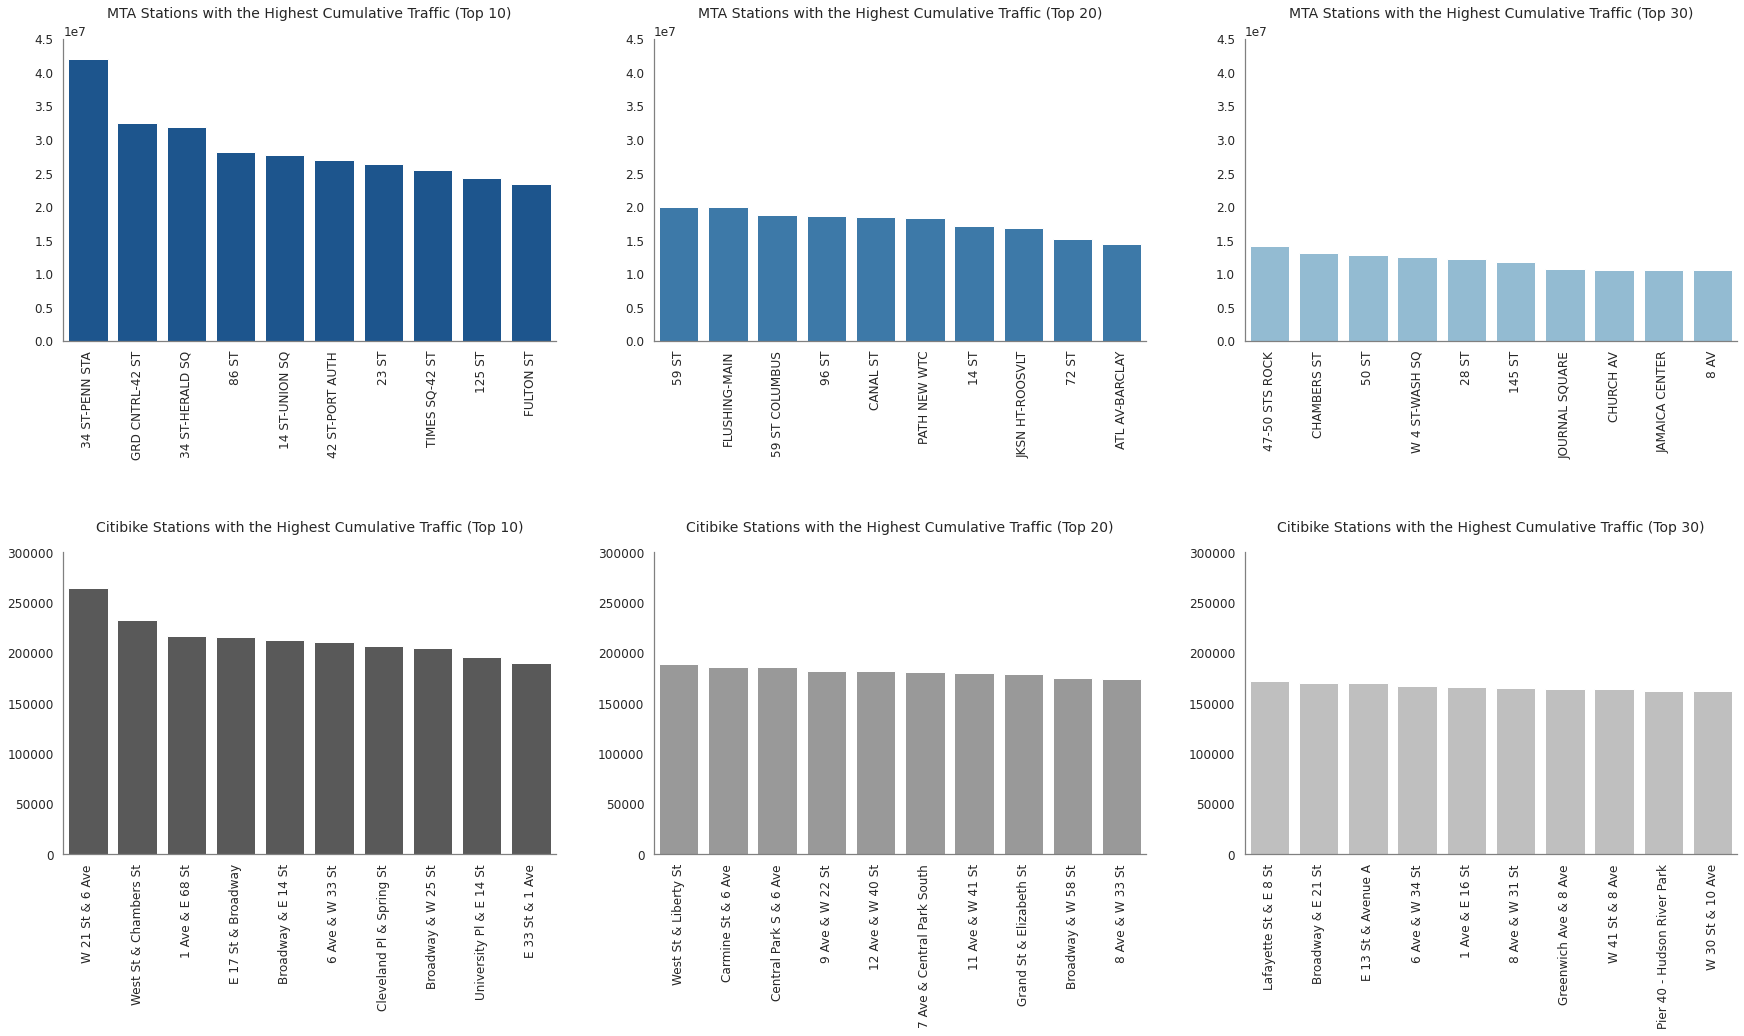

In [35]:
plt.figure(figsize=(30,15))

ax1=plt.subplot(2,3,1)
ax1.set_ylim([0, 45000000])
ax1=sns.barplot(x="STATION", y="TOTAL_TRAFFIC",color = '#0b559f',data=stations_totals_unpickled_top_30.head(10))
ax1.set_title("MTA Stations with the Highest Cumulative Traffic (Top 10)",y=1.05,fontdict= { 'fontsize': 14})
ax1.set_xticklabels(ax1.get_xticklabels(),rotation =90)
ax1.set(xlabel=None,ylabel=None)


ax2=plt.subplot(2,3,2)
ax2=sns.barplot(x="STATION", y="TOTAL_TRAFFIC",color= '#2b7bba',data=stations_totals_unpickled_top_30[10:20])
ax2.set_ylim([0, 45000000])
ax2.set_title("MTA Stations with the Highest Cumulative Traffic (Top 20)",y=1.05,fontdict= { 'fontsize': 14})
ax2.set_xticklabels(ax2.get_xticklabels(),rotation =90)
ax2.set(xlabel=None,ylabel=None)

ax3=plt.subplot(2,3,3)
ax3.set_ylim([0, 45000000])
ax3=sns.barplot(x="STATION", y="TOTAL_TRAFFIC",color= '#89bedc',data=stations_totals_unpickled_top_30[20:30])
ax3.set_title("MTA Stations with the Highest Cumulative Traffic (Top 30)",y=1.05,fontdict= { 'fontsize': 14})
ax3.set_xticklabels(ax3.get_xticklabels(),rotation =90)
ax3.set(xlabel=None,ylabel=None)
ax4=plt.subplot(2,3,4)

ax4=sns.barplot(x=citibike_station_count_top_30.head(10).index, y='Traffic',color= '#595959',data=citibike_station_count_top_30.head(10))
ax4.set_title("Citibike Stations with the Highest Cumulative Traffic (Top 10)",y=1.05,fontdict={'fontsize': 14})
ax4.set_xticklabels(ax4.get_xticklabels(),rotation =90)
ax4.set(xlabel=None,ylabel=None)
ax4.set_ylim([0, 300000])
ax5=plt.subplot(2,3,5)

ax5=sns.barplot(x=citibike_station_count_top_30[10:20].index, y='Traffic',color= '#999999',data=citibike_station_count_top_30[10:20])
ax5.set_title("Citibike Stations with the Highest Cumulative Traffic (Top 20)",y=1.05,fontdict={'fontsize': 14})
ax5.set_xticklabels(ax5.get_xticklabels(),rotation =90)
ax5.set(xlabel=None,ylabel=None)
ax5.set_ylim([0, 300000])

ax6=plt.subplot(2,3,6)

ax6=sns.barplot(x=citibike_station_count_top_30[20:30].index, y='Traffic',color= '#BFBFBF',data=citibike_station_count_top_30[20:30])
ax6.set_title("Citibike Stations with the Highest Cumulative Traffic (Top 30)",y=1.05,fontdict={'fontsize': 14})
ax6.set_xticklabels(ax6.get_xticklabels(),rotation =90)
ax6.set(xlabel=None,ylabel=None)
ax6.set_ylim([0, 300000])
plt.subplots_adjust(hspace = 0.7)
sns.despine()
ax1.spines['left'].set_color('grey')
ax1.spines['bottom'].set_color('grey')
ax2.spines['left'].set_color('grey')
ax2.spines['bottom'].set_color('grey')
ax3.spines['left'].set_color('grey')
ax3.spines['bottom'].set_color('grey')
ax4.spines['left'].set_color('grey')
ax4.spines['bottom'].set_color('grey')
ax5.spines['left'].set_color('grey')
ax5.spines['bottom'].set_color('grey')
ax6.spines['left'].set_color('grey')
ax6.spines['bottom'].set_color('grey')

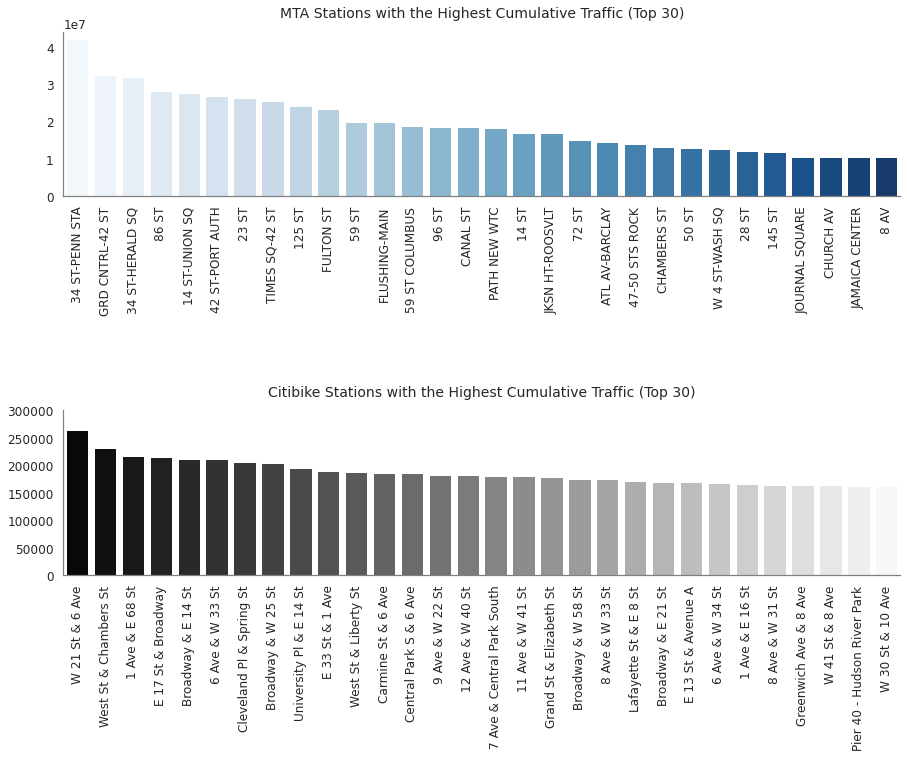

In [36]:
plt.figure(figsize=(15,10))

ax1=plt.subplot(2,1,1)
ax1=sns.barplot(x="STATION", y="TOTAL_TRAFFIC",palette = 'Blues',data=stations_totals_unpickled_top_30)
ax1.set_title("MTA Stations with the Highest Cumulative Traffic (Top 30)",y=1.05,fontdict= { 'fontsize': 14})
ax1.set_xticklabels(ax1.get_xticklabels(),rotation =90)
ax1.set(xlabel=None,ylabel=None)

ax2=plt.subplot(2,1,2)

ax2=sns.barplot(x=citibike_station_count_top_30.index, y='Traffic',palette= 'gray',data=citibike_station_count_top_30)
ax2.set_title("Citibike Stations with the Highest Cumulative Traffic (Top 30)",y=1.05,fontdict={'fontsize': 14})
ax2.set_xticklabels(ax2.get_xticklabels(),rotation =90)
ax2.set(xlabel=None,ylabel=None)
ax2.set_ylim([0, 300000])

plt.subplots_adjust(hspace = 1.3)
sns.despine()
ax1.spines['left'].set_color('grey')
ax1.spines['bottom'].set_color('grey')
ax2.spines['left'].set_color('grey')
ax2.spines['bottom'].set_color('grey')

In [37]:
#Plotting Top 30 MTA and Top 30 Citibike Option 2


# Part 3: Ratio of MTA Traffic to Citibike CapacityAnalysis 

## Merging MTA Traffic and MTA Coordinates Data on Station

In [52]:
#Loading from database dataset with 

In [53]:
mta_lat_long= pd.read_sql('SELECT STATION,LAT,LON FROM MTA_LAT_LONG;',engine)

In [54]:
mta_lat_long.head()

,STATION,LAT,LON
0,1 AV,40.731327,-73.982435
1,103 ST,40.796286,-73.961648
2,103 ST,40.796286,-73.961648
3,103 ST-CORONA,40.749827,-73.862746
4,104 ST,40.695146,-73.844305


In [55]:
#Merging coordinates data with traffic data on STATION columns 

In [56]:
stations_traffic_coord=pd.merge(station_totals,mta_lat_long,on="STATION").drop_duplicates(subset='STATION')
stations_traffic_coord.reset_index(inplace=True)
stations_traffic_coord=stations_traffic_coord.drop(columns='index')

In [57]:
#Keeping only the top 30 Stations in terms of Total Traffic
stations_traffic_coord_top30=stations_traffic_coord.sort_values('TOTAL_TRAFFIC',ascending=False).head(30)
stations_traffic_coord_top30

,STATION,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC,LAT,LON
0,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310
1,GRD CNTRL-42 ST,12844301.0,19543523.0,32387824.0,40.755861,-73.987061
2,34 ST-HERALD SQ,13074993.0,18757202.0,31832195.0,40.750087,-73.988127
3,86 ST,11639581.0,16443725.0,28083306.0,40.777741,-73.951567
4,14 ST-UNION SQ,10845407.0,16872027.0,27717434.0,40.734537,-73.990324
5,42 ST-PORT AUTH,11755532.0,15119367.0,26874899.0,40.757835,-73.991463
6,23 ST,11746327.0,14650272.0,26396599.0,40.741201,-73.989034
7,TIMES SQ-42 ST,10218372.0,15228480.0,25446852.0,40.755861,-73.987061
8,125 ST,10463039.0,13776164.0,24239203.0,40.804386,-73.937429
9,FULTON ST,9742964.0,13553967.0,23296931.0,40.710648,-74.009296


## Merging Top 30 Stations Traffic & Coordinates df with Citibike Stations coordinates df

In [58]:
#Loading citibike_stations excluding stations that have 0 capacity 

In [59]:
citibike_stations_df= pd.read_sql('SELECT name,latitude,longitude,capacity\
                                    FROM citibike_stations\
                                    WHERE capacity!=0;',engine)

In [60]:
citibike_stations_df.head()

,name,latitude,longitude,capacity
0,Newport Pkwy,40.728745,-74.032108,14
1,Kane St & Clinton St,40.686176,-73.996453,15
2,Adam Clayton Powell Blvd & W 151 St,40.825289,-73.936232,18
3,Tiebout Ave & E 184 St,40.858498,-73.896370,18
4,Monroe St & Classon Ave,40.684568,-73.958811,19


In [61]:
new_row = {'name':'E 17 St & Broadway', 'latitude':40.73705, 'longitude':73.99009, 'capacity':0,'key':1}

In [62]:
citibike_stations_df = citibike_stations_df.append(new_row, ignore_index=True)

In [63]:
#Creating a common key for both tables to be able to cross merge 
stations_traffic_coord_top30['key']=1
citibike_stations_df['key']=1
merged_mta_citibike_df = pd.merge(stations_traffic_coord_top30, citibike_stations_df, on ='key').drop("key", 1)
merged_mta_citibike_df

,STATION,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC,LAT,LON,name,latitude,longitude,capacity
0,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Newport Pkwy,40.728745,-74.032108,14
1,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Kane St & Clinton St,40.686176,-73.996453,15
2,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Adam Clayton Powell Blvd & W 151 St,40.825289,-73.936232,18
3,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Tiebout Ave & E 184 St,40.858498,-73.896370,18
4,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Monroe St & Classon Ave,40.684568,-73.958811,19
...,...,...,...,...,...,...,...,...,...,...
48205,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,Dean St & Hoyt St,40.686444,-73.987591,77
48206,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,48 Ave & 5 St,40.744363,-73.955873,79
48207,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,3 St & 3 Ave,40.675070,-73.987752,79
48208,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,Laight St & Hudson St,40.721854,-74.007718,91


In [64]:
#Renaming columns to avoid confusing between citibike data and mta data
merged_mta_citibike_df.rename(columns={"STATION":"MTA_STATION_NAME",
                                       "DAILY_ENTRIES":"MTA_DAILY_ENTRIES",
                                       "DAILY_EXITS":"MTA_DAILY_EXITS",
                                       "TOTAL_TRAFFIC":"MTA_TOTAL_TRAFFIC",
                                        "LAT":"MTA_LAT",
                                        "LON":"MTA_LON",
                                        "name":"CITIBIKE_STATION_NAME",
                                        "longitude":"CITIBIKE_LONGITUDE",
                                        "latitude":"CITIBIKE_LATITUDE",
                                        "capacity":"CITIBIKE_CAPACITY"},inplace=True)

In [65]:
#Concatenating Latitude and Longitude Station to be able to use geopy

In [66]:
merged_mta_citibike_df['MTA_LAT_LONG']=list(zip(merged_mta_citibike_df["MTA_LAT"], merged_mta_citibike_df["MTA_LON"]))
merged_mta_citibike_df['CITIBIKE_LAT_LONG']=list(zip(merged_mta_citibike_df["CITIBIKE_LATITUDE"], merged_mta_citibike_df["CITIBIKE_LONGITUDE"]))

In [67]:
#Calculing distance in km between each MTA Station and each Citibike

In [68]:
merged_mta_citibike_df['DIST'] = -1.5

for i in range(len(merged_mta_citibike_df)):
    merged_mta_citibike_df['DIST'][i] = GD(merged_mta_citibike_df['MTA_LAT_LONG'][i],merged_mta_citibike_df['CITIBIKE_LAT_LONG'][i]).km

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
merged_mta_citibike_df

,MTA_STATION_NAME,MTA_DAILY_ENTRIES,MTA_DAILY_EXITS,MTA_TOTAL_TRAFFIC,MTA_LAT,MTA_LON,CITIBIKE_STATION_NAME,CITIBIKE_LATITUDE,CITIBIKE_LONGITUDE,CITIBIKE_CAPACITY,MTA_LAT_LONG,CITIBIKE_LAT_LONG,DIST
0,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Newport Pkwy,40.728745,-74.032108,14,"(40.751056, -73.9903102)","(40.7287448, -74.0321082)",4.313107
1,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Kane St & Clinton St,40.686176,-73.996453,15,"(40.751056, -73.9903102)","(40.6861758, -73.99645295)",7.223517
2,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Adam Clayton Powell Blvd & W 151 St,40.825289,-73.936232,18,"(40.751056, -73.9903102)","(40.825289, -73.936232)",9.422854
3,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Tiebout Ave & E 184 St,40.858498,-73.896370,18,"(40.751056, -73.9903102)","(40.858498, -73.89637)",14.324662
4,34 ST-PENN STA,17146189.0,24826860.0,41973049.0,40.751056,-73.990310,Monroe St & Classon Ave,40.684568,-73.958811,19,"(40.751056, -73.9903102)","(40.6845683, -73.95881081)",7.848402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48205,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,Dean St & Hoyt St,40.686444,-73.987591,77,"(40.7404298, -74.0017765)","(40.6864442, -73.98759104)",6.113669
48206,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,48 Ave & 5 St,40.744363,-73.955873,79,"(40.7404298, -74.0017765)","(40.74436328706688, -73.9558732509613)",3.901605
48207,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,3 St & 3 Ave,40.675070,-73.987752,79,"(40.7404298, -74.0017765)","(40.6750705, -73.98775226)",7.354157
48208,8 AV,4752339.0,5743707.0,10496046.0,40.740430,-74.001777,Laight St & Hudson St,40.721854,-74.007718,91,"(40.7404298, -74.0017765)","(40.72185379, -74.00771779)",2.123021


In [70]:
#Selecting Only Distance below 0.5 km

In [71]:
one_km_dist=merged_mta_citibike_df[merged_mta_citibike_df["DIST"]<0.5].reset_index()

In [72]:
#Getting the total number of citibikes in a one km area corresponding to one MTA STATION

In [73]:
one_km_dist_ratio=one_km_dist.groupby(['MTA_STATION_NAME','MTA_TOTAL_TRAFFIC'])\
['CITIBIKE_CAPACITY'].sum().reset_index()

In [74]:
#Calclulating ratio of traffic to citibike stations

In [75]:
one_km_dist_ratio['RATIO']= one_km_dist_ratio['MTA_TOTAL_TRAFFIC']/one_km_dist_ratio['CITIBIKE_CAPACITY']

In [76]:
sorted_ratios=one_km_dist_ratio.sort_values('MTA_TOTAL_TRAFFIC')

In [77]:
sorted_ratios

,MTA_STATION_NAME,MTA_TOTAL_TRAFFIC,CITIBIKE_CAPACITY,RATIO
14,8 AV,10496046.0,540,19437.122222
20,CHURCH AV,10596734.0,51,207779.098039
23,JOURNAL SQUARE,10636184.0,96,110793.583333
3,145 ST,11802173.0,201,58717.278607
5,28 ST,12160761.0,467,26040.173448
26,W 4 ST-WASH SQ,12552266.0,665,18875.587970
10,50 ST,12790426.0,651,19647.351767
19,CHAMBERS ST,13114019.0,519,25267.859345
9,47-50 STS ROCK,14114991.0,452,31227.856195
17,ATL AV-BARCLAY,14397364.0,361,39881.894737


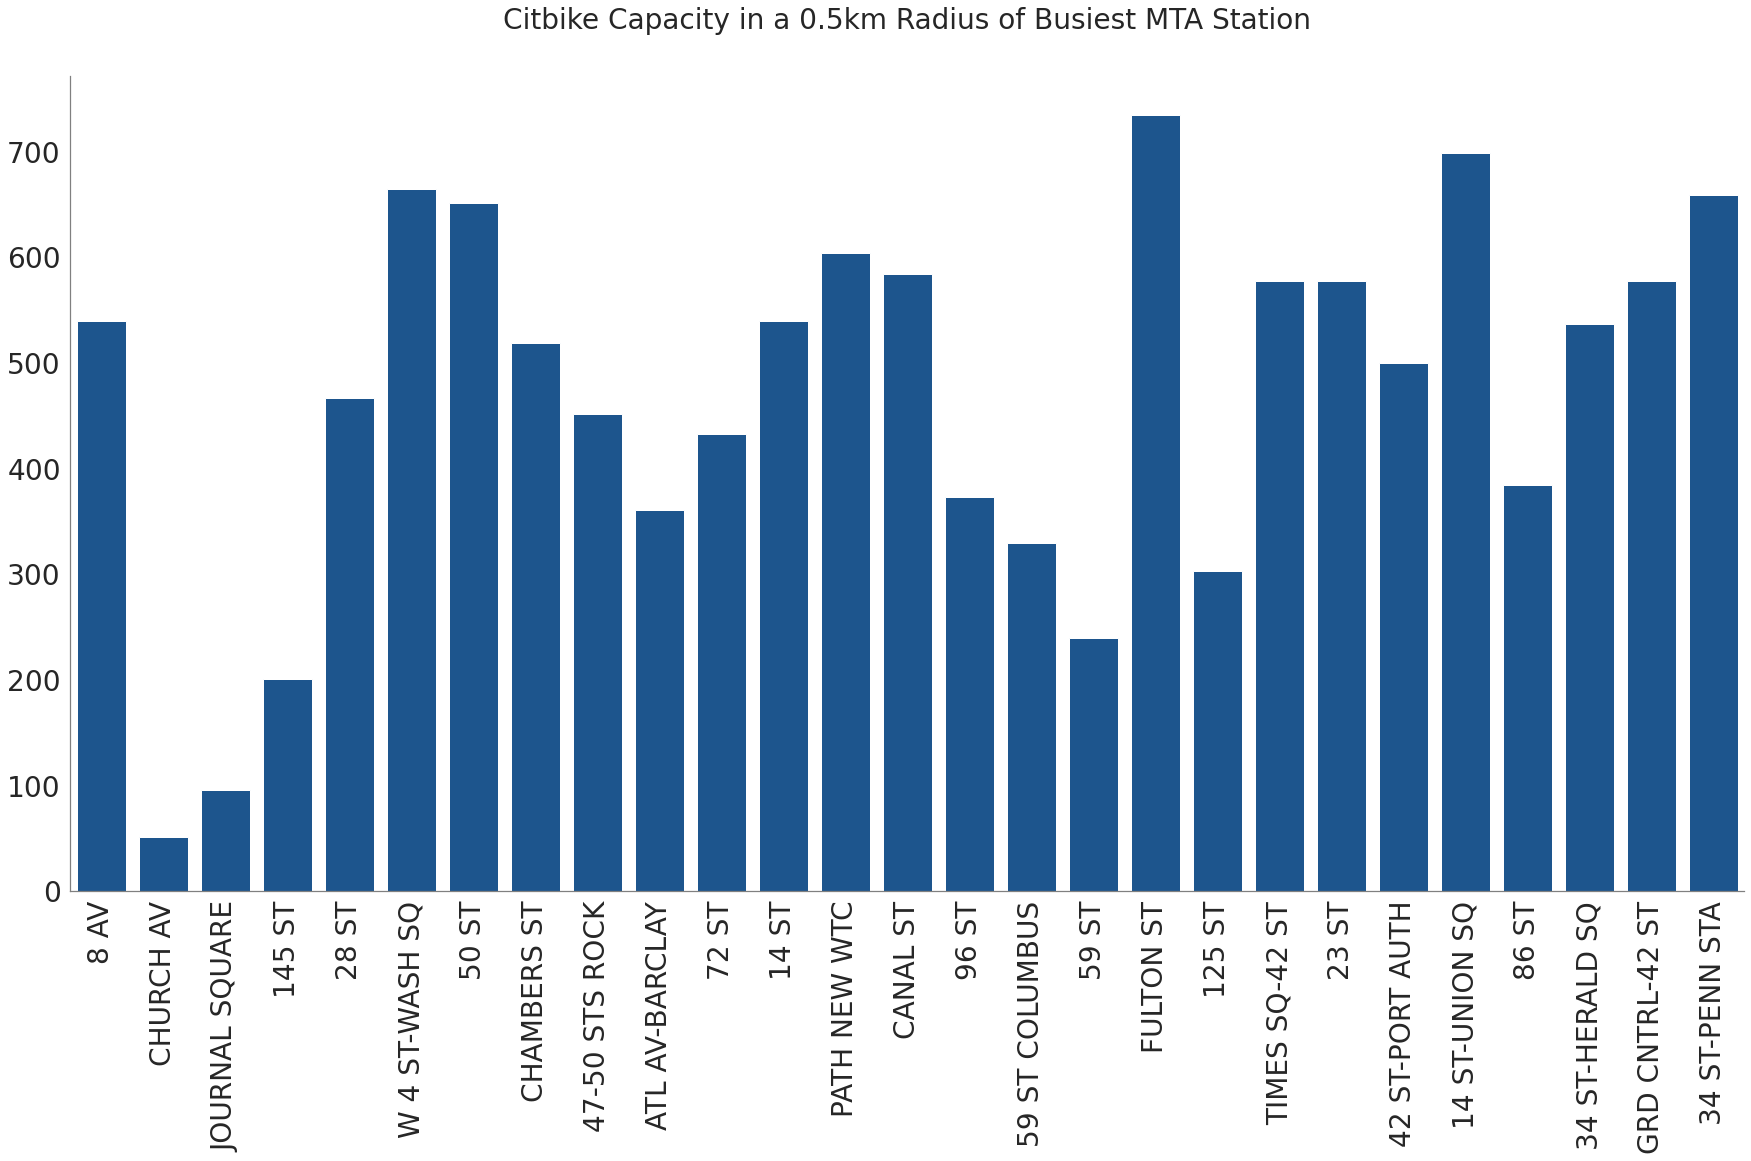

In [79]:
plt.figure(figsize=(30,15))

ax1=plt.subplot(1,1,1)
ax1=sns.barplot(x="MTA_STATION_NAME", y="CITIBIKE_CAPACITY",color = '#0b559f',data=sorted_ratios)
ax1.set_title("Citbike Capacity in a 0.5km Radius of Busiest MTA Station",y=1.05,fontdict= { 'fontsize': 28})
ax1.set_xticklabels(ax1.get_xticklabels(),rotation =90)
ax1.set(xlabel=None,ylabel=None)
sns.despine()
ax1.spines['left'].set_color('grey')
ax1.spines['bottom'].set_color('grey')
ax1.tick_params(axis='both', which='major', labelsize=28)


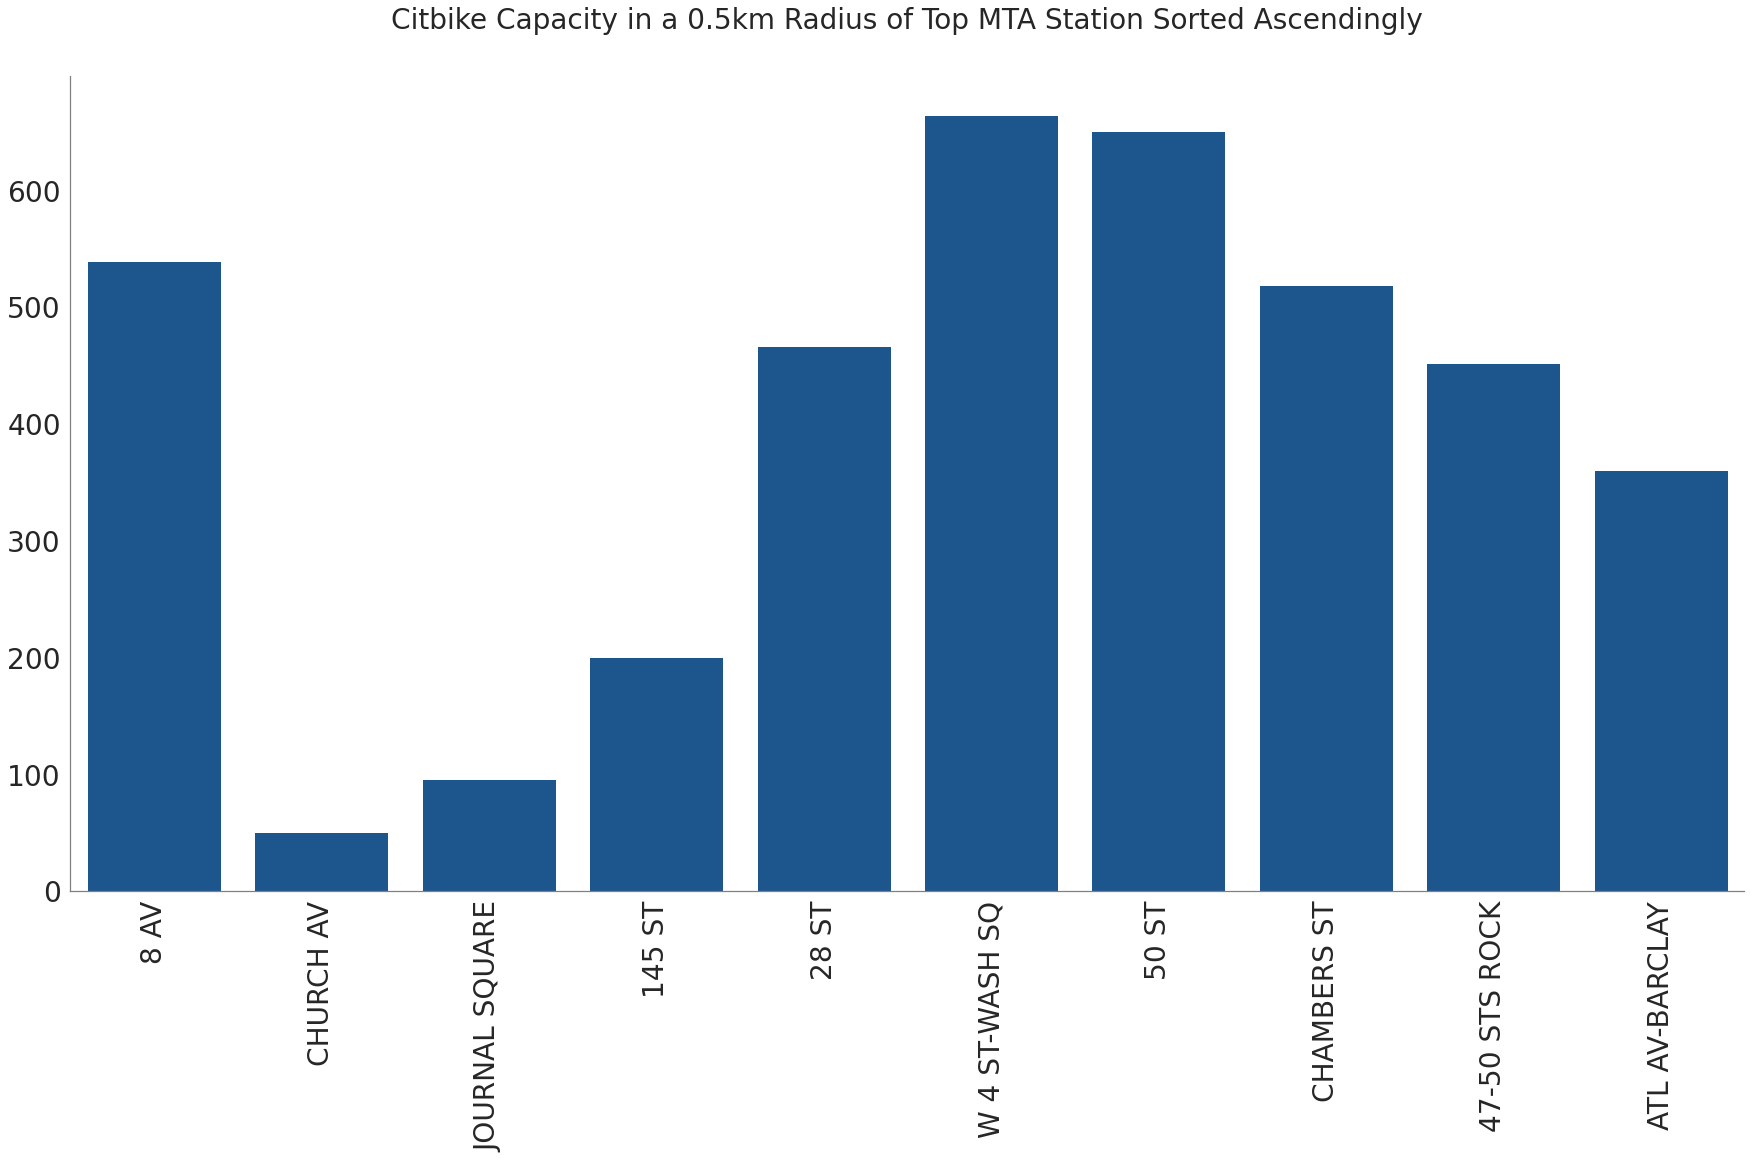

In [131]:
plt.figure(figsize=(30,15))

ax1=plt.subplot(1,1,1)
ax1=sns.barplot(x="MTA_STATION_NAME", y="CITIBIKE_CAPACITY",color = '#0b559f',data=sorted_ratios.head(10))
ax1.set_title("Citbike Capacity in a 0.5km Radius of Top MTA Station Sorted Ascendingly",y=1.05,fontdict= { 'fontsize': 28})
ax1.set_xticklabels(ax1.get_xticklabels(),rotation =90)
ax1.set(xlabel=None,ylabel=None)
sns.despine()
ax1.spines['left'].set_color('grey')
ax1.spines['bottom'].set_color('grey')
ax1.tick_params(axis='both', which='major', labelsize=28)


# Using Folium to Visualize Traffic on a Map

In [157]:
citibike_station_count_top_30

,Traffic
W 21 St & 6 Ave,264215.0
West St & Chambers St,232292.0
1 Ave & E 68 St,216900.0
E 17 St & Broadway,215969.0
Broadway & E 14 St,212477.0
6 Ave & W 33 St,211092.0
Cleveland Pl & Spring St,206754.0
Broadway & W 25 St,204489.0
University Pl & E 14 St,195474.0
E 33 St & 1 Ave,189977.0


In [172]:
citibike_stations_df_lat_lon=citibike_stations_df[citibike_stations_df.name.isin(citibike_station_count_top_30.index)]

In [178]:
citibike_stations_df_lat_lon=citibike_stations_df_lat_lon.reset_index().drop('index',axis=1)

In [181]:
citibike_stations_df_lat_lon=citibike_stations_df_lat_lon.iloc[list(map(citibike_stations_df_lat_lon['name'].tolist().index,citibike_station_count_top_30.index ))].reset_index().drop('index',axis=1)

In [182]:
citibike_stations_df_lat_lon

,name,latitude,longitude,capacity,key
0,W 21 St & 6 Ave,40.741740,-73.994156,50,1
1,West St & Chambers St,40.717548,-74.013221,81,1
2,1 Ave & E 68 St,40.765005,-73.958185,62,1
3,E 17 St & Broadway,40.737050,73.990090,0,1
4,Broadway & E 14 St,40.734546,-73.990741,78,1
5,6 Ave & W 33 St,40.749013,-73.988484,52,1
6,Cleveland Pl & Spring St,40.722104,-73.997249,33,1
7,Broadway & W 25 St,40.742869,-73.989186,54,1
8,University Pl & E 14 St,40.734814,-73.992085,61,1
9,E 33 St & 1 Ave,40.743227,-73.974498,83,1


In [184]:
nycmap = folium.Map(location=[40.767937,-73.982155 ], tiles='Stamen Toner', zoom_start=12)
nycmap
for i,row in stations_traffic_coord_top30.iterrows():
    if i<10:
        folium.CircleMarker((row.LAT,row.LON), radius=10, weight=2, \
                        color='blue', fill_color='blue', fill_opacity=.5).add_to(nycmap)
    elif i<20:
        folium.CircleMarker((row.LAT,row.LON), radius=5, weight=2, \
                        color='blue', fill_color='blue', fill_opacity=.5).add_to(nycmap)
    else:
        folium.CircleMarker((row.LAT,row.LON), radius=2, weight=2, \
                        color='blue', fill_color='blue', fill_opacity=.5).add_to(nycmap)

In [187]:
for i,row in citibike_stations_df_lat_lon.iterrows():
    if i<10:
        folium.CircleMarker((row.latitude,row.longitude), radius=10, weight=2, \
                        color='gray',fill_color='gray',fill_opacity=.5).add_to(nycmap)
    elif i<20:
        folium.CircleMarker((row.latitude,row.longitude), radius=5, weight=2, \
                        color='gray',fill_color='gray',fill_opacity=.5).add_to(nycmap)
    else:
        folium.CircleMarker((row.latitude,row.longitude), radius=2, weight=2, \
                        color='gray',fill_color='gray',fill_opacity=.5).add_to(nycmap)

In [188]:
nycmap